In [1]:
%reset-f
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:

import numpy as np

from res_ind_lib import *


import os, time

import warnings
warnings.filterwarnings("always",category=UserWarning)

from sorted_nicely import *
from replace_with_warning import *

In [3]:
import pandas as pd

#Pandas display options
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', 200)
pd.set_option('display.precision', 10)
pd.set_option('display.max_rows', 500)


# Options

In [4]:
protection_from_flopros = True

### Country dictionaries

In [5]:
#Names to WB names
any_to_wb = pd.read_csv("inputs/any_name_to_wb_name.csv",index_col="any",squeeze=True)


# Data

##  Economic data from the world bank

In [6]:
nb_weeks = (time.time()-os.stat("inputs/wb_data.csv").st_mtime )/(3600*24*7)
if nb_weeks>20: 
    warnings.warn("World bank data are "+str(int(nb_weeks))+" weeks old. You may want to download them again.")
df=pd.read_csv("inputs/wb_data.csv").set_index("country")
df.dropna().shape


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: World bank data are 23 weeks old. You may want to download them again.
  app.launch_new_instance()


(73, 12)

In [7]:
#Income gorups for countries and HIPC status
groups = pd.read_csv("inputs/income_groups.csv",header =4,index_col=2).replace({"ROM":"ROU","ZAR":"COD"})  #they used old iso3 country for Zair (Congo) and Romania
groups= groups[["Code","Region","Income group","Lending category","Other"]]
groups.dropna(axis=0,how="all",inplace=True);
groups.rename(columns={"Other":"HIPC"},inplace=True)
groups['HIPC'].fillna('',inplace=True)
groups["Lending category"].replace("..","",inplace=True)

df["iso3"]=groups["Code"]


### EUsilc and other countries

In [8]:
silc = pd.read_csv("inputs/social_ratios.csv")
#EU cuntry code to iso2 
silc["iso2"]=silc["cc"].replace({"EL":"GR","UK":"GB"}) #Greece and UK
silc.set_index("iso2",inplace=True)

#iso3 to wb country name table
iso3_to_wb=pd.read_csv("inputs/iso3_to_wb_name.csv").set_index("iso3")

#iso2 to iso3 table
iso2_iso3 = pd.read_csv("inputs/names_to_iso.csv", usecols=["iso2","iso3"]).drop_duplicates().set_index("iso3") #the tables has more lines than countries to account for several ways of writing country names

#iso2 to WB 
iso2_iso3["country"]=iso3_to_wb["country"]
iso2_country=iso2_iso3.reset_index().set_index("iso2")

#indexes this data by WB country
silc["country"]=iso2_country["country"]
silc.set_index("country",inplace=True)
#silc.drop_duplicates(inplace=True)

#Monitoring differences between SILC and ASPIRE
#hop=df.ix[silc.index,["social_p","social_r"]].dropna().rename(columns=dict(social_p = "s_p_aspire", social_r="s_r_aspire"))
#hop[["sp_silc","sr_silc"]]= silc.ix[hop.index,["social_p","social_r"]]
#plt.scatter(x=hop.sp_silc,y=hop.s_p_aspire), plt.scatter(x=hop.sr_silc,y=hop.s_r_aspire,c="red")

df.ix[silc.index,["social_p","social_r"]]=silc[["social_p","social_r"]]

### Definitions

In [9]:
# share of poor individuals, we chose the bottom 20
ph=df["pov_head"]=0.2 

### HFA

gets hfa data

In [10]:
# READ THE LAST HFA DATA
hfa_newest =   pd.read_csv("inputs/HFA_all_2011_2013.csv")
hfa_newest["country"]=replace_with_warning(hfa_newest["Country name"],any_to_wb)

# READ THE PREVIOUS HFA DATA
hfa_previous = pd.read_csv("inputs/HFA_all_2009_2011.csv")
hfa_previous["country"]=replace_with_warning(hfa_previous["Country name"],any_to_wb)

#most recent values... if no 2011-2013 reporting, we use 2009-2011
hfa_oldnew=pd.concat([hfa_newest.set_index("country"), hfa_previous.set_index("country")], axis=1,keys=['new', 'old']) #this is important to  join the list of all countries
hfa = hfa_oldnew["new"].fillna(hfa_oldnew["old"]);

# access to early warning = priority for action 2, indicator 3 of the HFA
hfa["shew"]=1/5*hfa["P2-C3"] # between zero and 1. 

# ability to scale up = average of priority for action 5 of the HFA
hfa["prepare_scaleup"]=(hfa["P4-C2"]+hfa["P5-C2"]+hfa["P4-C5"])/3/5 # between zero and 1
hfa["finance_pre"] = hfa["P5-C3"]/5 #betwenn 0 and 1


df[["shew","prepare_scaleup","finance_pre"]]=hfa[["shew","prepare_scaleup","finance_pre"]]

#assumes no reporting is bad situation (caution! do the fillna after inputing to df)
df[["shew","prepare_scaleup","finance_pre"]]=df[["shew","prepare_scaleup","finance_pre"]].fillna(0)


### Country Ratings

In [11]:
#Reads the data and check its not too old
the_credit_rating_file ="inputs/cred_rat.csv"
nb_weeks = (time.time()-os.stat(the_credit_rating_file).st_mtime )/(3600*24*7)
if nb_weeks>3: 
    warnings.warn("Credit ratings are "+str(int(nb_weeks))+" weeks old. Get new ones at http://www.tradingeconomics.com/country-list/rating")
ratings_raw  =pd.read_csv(the_credit_rating_file,dtype="str").dropna(how="all")
ratings_raw=ratings_raw.rename(columns={"Unnamed: 0": "country_in_ratings"})[["country_in_ratings","S&P","Moody's","Fitch"]]

#The creidt rating sources calls DR Congo just Congo
ratings_raw.country_in_ratings= ratings_raw.country_in_ratings.str.strip().replace(["Congo"],["Congo, Dem. Rep."])

ratings_raw["country"]= replace_with_warning(ratings_raw.country_in_ratings.apply(str.strip),any_to_wb)

ratings_raw=ratings_raw.set_index("country")

def mystriper(string):
    """strip blanks and converts everythng to lower case"""
    if type(string)==str:
        return str.strip(string).lower()
    else:
        return string
        
#to lower case and strips blanks
ratings_raw=ratings_raw.applymap(mystriper)    

#Transforms ratings letters into 1-100 numbers
rat_disc = pd.read_csv("inputs/cred_rat_dict.csv")
ratings=ratings_raw
ratings["S&P"].replace(rat_disc["s&p"].values,rat_disc["s&p_score"].values,inplace=True)
ratings["Moody's"].replace(rat_disc["moodys"].values,rat_disc["moodys_score"].values,inplace=True)
ratings["Fitch"].replace(rat_disc["fitch"].values,rat_disc["fitch_score"].values,inplace=True)
ratings["rating"]=ratings.mean(axis=1)/100

df["rating"] = ratings["rating"]
df["rating"].fillna(0,inplace=True)  #assumes no rating is bad rating

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Credit ratings are 23 weeks old. Get new ones at http://www.tradingeconomics.com/country-list/rating


### Capital data

In [12]:
#data arranged from Penn tables
k_data=pd.read_csv("inputs/capital_data.csv", usecols=["code","cgdpo","ck"]).replace({"ROM":"ROU","ZAR":"COD"}).rename(columns={"cgdpo":"prod_from_k","ck":"k"})#Zair is congo

#matches names in the dataset with world bank country names
iso_country = pd.read_csv("inputs/iso3_to_wb_name.csv", index_col="iso3")
k_data.set_index("code",inplace=True)
k_data["country"]=iso_country["country"]
cond = k_data["country"].isnull()
if cond.sum()>0:
     warnings.warn("this countries appear to be missing from iso3_to_wb_name.csv: "+" , ".join(k_data.index[cond].values))
k_data=k_data.reset_index().set_index("country")

# average productivity of capital
df["avg_prod_k"]=k_data["prod_from_k"]/k_data["k"]


### Hazard (protection)

In [13]:
#df.protection.head()
if protection_from_flopros:
#protection from FLOPROS
    minrp = 1/2 #assumes nobody is flooded more than twice a year
    df["protection"]= pd.read_csv("inputs/protection_national_from_flopros.csv", index_col="country", squeeze=True 
                                 ).clip(lower=minrp)
else:
    #assumed a function of the income group
    protection_assumptions = pd.read_csv("inputs/protection_level_assumptions.csv", index_col="Income group")
    df["protection"]=groups["Income group"].replace(protection_assumptions["protection"])


### Exposure (population in flood-prone areas)

In [14]:
#Esposure data, by return peridd 
expo = pd.read_csv("inputs/exposure_econ_return_period.csv",index_col="country");


df["fa"]=expo["100"]

fa_ratios = expo.div(df["fa"],axis=0).dropna()

fa_ratios.columns=fa_ratios.columns.map(float)
fa_ratios.columns

fa_ratios=fa_ratios.sort_index(axis=1)

fa_ratios.to_csv("inputs/fa_ratios.csv")

In [15]:
def wavg(data,weights):
    df_matched =pd.DataFrame({"data":data,"weights":weights}).dropna()
    return (df_matched.data*df_matched.weights).sum()/df_matched.weights.sum()

In [16]:
#Exposure bias from WB DELTARES study
PEB_wb_deltares = pd.read_csv("inputs/PEB_wb_deltares.csv",skiprows=[0,1,2],usecols=["Country","Nation-wide"])
PEB_wb_deltares["country"] = replace_with_warning(PEB_wb_deltares["Country"],any_to_wb)
df["pe"]= PEB_wb_deltares.set_index("country").drop(["Country"],axis=1).squeeze()
df["pe"]=df["pe"].fillna(wavg(df["pe"],df["pop"]))

pe=df["pe"]

### Vulnerability

In [17]:
#Reads data from pager
pager=pd.read_csv("inputs/pager_vulnerabilities.csv",
                  usecols=["ISO-3digit","R_1","R_2","R_3","VV_1","VV_2","VV_3","Country Name"],
                  index_col="ISO-3digit")

#indexes pager data by country        
pager["country"]=iso3_to_wb["country"]
cond = pager["country"].isnull()
if cond.sum()>0:
     warnings.warn("this countries appear to be missing from iso3_to_wb_name.csv: "+" , ".join(pager.index[cond].values)+".\nThese are: "+" , ".join(pager.ix[cond,"Country Name"].values) )
pager["country"]=iso3_to_wb["country"]
hop=pager.dropna().reset_index().set_index("country")

#sorts vulnerabilites according to income
share =hop[["R_1","R_2","R_3"]]
damrat=hop[["VV_1","VV_2","VV_3"]]

damrat.columns=["R_1","R_2","R_3"]
p=(share.cumsum(axis=1)-ph).clip(lower=0)
poor=(share-p).clip(lower=0)


vp=(poor*damrat).sum(axis=1)/poor.sum(axis=1)
rich=share-poor

vr=(rich*damrat).sum(axis=1)/rich.sum(axis=1)


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: UserWarning: this countries appear to be missing from iso3_to_wb_name.csv: ALA , ATA , BES , BVT , IOT , CXR , CCK , FLK , GUF , ATF , GIB , GLP , GGY , HMD , VAT , JEY , MTQ , MYT , MSR , NFK , PCN , REU , BLM , SHN , SPM , SGS , SJM , TKL , UMI , WLF , ESH.
These are: Aland Islands , Antarctica , Bonaire , Bouvet Island , British Indian Ocean Territory , Christmas Island , the Cocos (Keeling) Islands , the Falkland Islands (Malvinas) , French Guiana , the French Southern Territories , Gibraltar , Guadeloupe , Guernsey , Heard Island and McDonald Islands , the Holy See (Vatican City State) , Jersey , Martinique , Mayotte , Montserrat , Norfolk Island , Pitcairn , Reunion , Saint Barthelemy , Saint Helena , Saint Pierre and Miquelon , South Georgia and the South Sandwich Islands , Svalbard and Jan Mayen , Tokelau , the United States Minor Outlying Islands , Wallis and Futuna , Western Sahara


In [18]:
#Expresses vulnerability as total and bias

fa=df["fa"]
fap=fa*(1+pe)
far=(fa-ph*fap)/(1-ph)

cp=   df["share1"] /.2*df["gdp_pc_pp"]
cr=(1-df["share1"])/.8*df["gdp_pc_pp"]

df["v"]  = (ph*vp*cp*fap + (1-ph)*vr*cr*far)/(ph*cp*fap + (1-ph)*cr*far)
df["pv"] =  vp/df.v-1

#vulnerability of diversified (shared) capital
df["v_s"]=vr



#### "protected" variables

In [19]:
df=def_ref_values(df)



### Homogenity of losses

In [20]:
#resds loss distribution in mumbai
hop=pd.read_csv("inputs/losses_distribution_mumbai.csv",index_col=0)["losses/asset_cost"]
# standard deviation of the underlying normal distribution
s = np.log(hop).std() 

df["H"]= np.exp (-s**2/2)


## Report missing data for the national studies

In [21]:
def write_missing_data(s):
    which = s[s.isnull()].index.values
    return ", ".join(which)

def count_missing_data(s):
    return s.isnull().sum()

report = pd.DataFrame()

report["nb_missing"]=df.apply(count_missing_data,axis=1)  
report["missing_data"]=df.apply(write_missing_data,axis=1)

report  = report.ix[report["nb_missing"]>0,:]
report.sort_values(by="nb_missing",inplace=True)
report.to_csv("results/missing_data_report.csv")

report.head()

,nb_missing,missing_data
country,,
Djibouti,1,unemp
Iraq,1,plgp
Togo,1,social_p
Nicaragua,1,avg_prod_k
"Macedonia, FYR",2,"social_p, social_r"


## manual parametrization

In [22]:
# no ripple effects
df["alpha"] =1 

#Reconstruction time
df["T_rebuild_K"] = 3
df["T_rebuild_L"] = 40

# how much early warning reduces vulnerability
df["pi"] = 0.2

#income elasticity
df["income_elast"] = 1.5

In [23]:
(df.social_p * cp).ix["Bolivia"]/365, (df.social_r * cr).ix["Bolivia"]/365

(0.93709161246631767, 4.4576453933694689)

# Computes and saves national resilience

Central cases

In [24]:
df["original_country"]=df.index;
#saves orginal dataframe before adding columns with results
df.drop("iso3", axis=1).to_csv("results/df_original.csv")
df.ix["France"];

In [25]:
args = dict(fa_ratios=fa_ratios, verbose_output=True)
#args = dict()

In [26]:
df_with_results=compute_resiliences(df.dropna(),**args)
print("nb countries with all data :"+str(df.dropna().shape[0]))

nb_countries_all_results = df_with_results["resilience"].dropna().shape[0]
print("nb countries with all data and results :"+str(nb_countries_all_results))
df_with_results.to_csv("results/df.csv",float_format="%.5f")


#Some stats
a=df_with_results.resilience;
a.min()*100,a.mean()*100,a.max()*100
print("Resilience averages {mean:.0%} across our sample, ranging from {min:.0%} to {max:.0%}".format(
        min=a.min(),mean=a.mean(),max=a.max()))

a=df_with_results.risk
a.argmax(), a.max()
print("Risk averages {mean:.03%} across our sample, ranging from {min:.03%} ({m}) to {max:.03%} ({M})".format(
    min=a.min(),mean=a.mean(),max=a.max(),m=a.argmin(),M=a.argmax()))


#magic redistribution
df_share1 = compute_resiliences( df.dropna().assign(share1=df.share1+1/100), **args )

#welfare losses
wa=df_with_results.total_equivalent_cost.sum()*1e-9
wb=df_share1.total_equivalent_cost.sum()*1e-9

#asset losses
ka = (df_with_results.dKtot/df.protection).sum()*1e-9
kb = (df_share1.dKtot/df_share1.protection).sum()*1e-9

print(" Increasing the share of income of the bottom quintile by 1 percent in the {nb} countries \
would increase asset losses from USD {ka:0.1f} to {kb:0.1f} billions per year \
(+{XX:.2f} percent), but reduce welfare losses by {YY:.2} percent".format(
        XX=100*(kb-ka)/ka,ka=ka,kb=kb,YY=100*(wa-wb)/wa,nb=nb_countries_all_results))


df_with_results.ix[["Denmark", "Netherlands","Malawi", "Bangladesh", "Jamaica", "Congo, Dem. Rep."],["protection", "risk", "v","fa", "resilience"]]

nb countries with all data :90
nb countries with all data and results :90
Resilience averages 61% across our sample, ranging from 25% to 86%
Risk averages 0.690% across our sample, ranging from 0.004% (Netherlands) to 4.852% (Congo, Dem. Rep.)
 Increasing the share of income of the bottom quintile by 1 percent in the 90 countries would increase asset losses from USD 7.1 to 7.2 billions per year (+0.65 percent), but reduce welfare losses by 3.4 percent


,protection,risk,v,fa,resilience
country,,,,,
Denmark,25.74,0.0001442347,0.1255456327,0.0054214952,0.7785517532
Netherlands,4489.59,0.0000394384,0.1282233263,0.3364405974,0.7530701744
Malawi,2.84,0.0123138410,0.3247000293,0.0175697219,0.5315805964
Bangladesh,50.00,0.0076002225,0.3799778384,0.2220788331,0.6420628477
Jamaica,0.50,0.0006032131,0.2674819826,0.0002613958,0.4953676161
"Congo, Dem. Rep.",2.04,0.0485233824,0.5111220524,0.0271273538,0.6005394607


 # Basic reporting

In [27]:
#Outputs table with main results
to_output = ['gdp_pc_pp', 'pop',"protection","v","resilience","risk"]
a=df_with_results[to_output].copy()

a["fa_in_gdp"] =  df_with_results["fa"]/ df_with_results["avg_prod_k"]


a.loc[:,["fa_in_gdp","v","resilience","risk"]]=100*a[["fa_in_gdp","v","resilience","risk"]]
desc=pd.read_csv("inputs/inputs_info.csv").set_index('key')["descriptor"]
a.rename(columns=desc).dropna().to_excel("results/results.xlsx")
a.head()

,gdp_pc_pp,pop,protection,v,resilience,risk,fa_in_gdp
country,,,,,,,
Albania,9960.9407258136,2897366.0000000023,15.54,33.8132339888,71.0211454641,1.1855183194,38.1635758960
Argentina,18087.1962616822,41446246.0000000000,64.41,32.2966988087,52.8807301188,0.2105499167,27.3188306108
Armenia,7526.8364191129,2976566.0000000009,11.46,12.4405654902,69.0775493726,0.1337053027,9.4712040237
Australia,42834.0167597384,23129300.0000000000,100.00,44.6881422566,71.3353829524,0.0758328841,15.5550449816
Austria,44056.2544168020,8479823.0000000000,600.59,16.0050032938,69.2367093423,0.0141052156,37.5570135174


#### countries for which pov traps matter

In [28]:
((df_with_results.resilience_no_shock - df_with_results.resilience)).sort_values(ascending=False).head()

country
Rwanda          0.1258713663
Liberia         0.1060752803
Cambodia        0.0840468680
Sierra Leone    0.0795179865
Pakistan        0.0719065915
dtype: float64

## sensitivity anlysis

In [29]:
####Sensitivity analysis following instructions in alt_params.csv

country_sens_list=["Malawi","Sweden"]

#reads paramters to be varied
alt_params=pd.read_csv("inputs/alt_params.csv")

df_sensit = pd.DataFrame(columns=df.columns)

for c in country_sens_list:

    for p in alt_params.index.tolist():
        param = alt_params.ix[p,"param"]
        
        new_value = alt_params.ix[p,"value"]
        if new_value[0] in "/*":
            new_value = str(df.ix[c,param])+new_value         
        new_value = eval(new_value)
        
        if alt_params.ix[p,"unit"]=="%":
            suffix = " $({name}={nv:2.0f}\%)$".format(name=alt_params.ix[p,"formated_name"],nv=100*new_value) 
        else    :
            suffix = " $({name}={nv:2.0f}{unit})$".format(name=alt_params.ix[p,"formated_name"],nv=new_value, unit =alt_params.ix[p,"unit"] )
        d = c+suffix
        df_sensit.ix[d] = df.ix[c]
        df_sensit.ix[d,param] =new_value
        df_sensit.ix[d,"original_country"]=c
        
        #sets reference values 
        df_sensit =def_ref_values(df_sensit)
        
    
    #special treatment for fa
    #df_sensit.ix[d,param] =new_value
    
for c in df.dropna().index: #senstitivity for all countries  (actually very long)    
    for param in ["income_elast"]:
        for new_value in [1, 2]:
            d = c+" $(\eta="+str(new_value)+")$"
            df_sensit.ix[d] = df.ix[c]
            df_sensit.ix[d,param] =new_value
            df_sensit.ix[d,"original_country"]=c

df_sensit=df_sensit.sort_index().sort_index(axis=1)            
            
df_sensit.index.name="country"; #after adding indices pandas forgets their 
df_sensit.drop("iso3", axis=1).to_csv("results/df_sensit_input.csv")

fa_ratios_sensib= df_sensit[["original_country"]].merge(fa_ratios,right_index=True,left_on="original_country").drop(["original_country"], axis=1)
fa_ratios_sensib.to_csv("results/fa_ratios_sensib.csv")

compute_resiliences(df_sensit, fa_ratios=fa_ratios_sensib).to_csv("results/df_sensit_results.csv")

# Simple OLSs

## Resilience

In [30]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [31]:
experiments_cols=[
'axfin_p', 'axfin_r', 'axhealth', 'bashs', 'finance_pre', 'ophe', 'avg_prod_k', 
       'pe',  'plgp',  'prepare_scaleup',  'pv', 'rating', 'share1', 'social_p', 'social_r', 'unemp']
varin = "resilience"

formula = varin+" ~ " + "+".join(experiments_cols)
olsmodel=ols(formula,data=df_with_results).fit()
olsmodel.summary()

pd.DataFrame( [olsmodel.params, olsmodel.pvalues], index=["coeff", "pval"]).T
olsmodel.summary()
# table=anova_lm(olsmodel)
# table['sum_sq_pc']=table['sum_sq']/table['sum_sq'].sum()
# b=table.sort_values(by="sum_sq_pc", ascending=False)["sum_sq_pc"].reset_index()
# b["desc"]=b["index"].replace(pd.read_csv("inputs_info.csv",usecols=["key","descriptor"],index_col="key",squeeze=True))
# b=b.set_index("desc").drop("index",axis=1)
# b.to_csv("anova.csv")
# b.head(12)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             resilience   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     70.59
Date:                Mon, 09 May 2016   Prob (F-statistic):           1.45e-37
Time:                        18:48:40   Log-Likelihood:                 171.27
No. Observations:                  90   AIC:                            -310.5
Df Residuals:                      74   BIC:                            -270.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.4399      0.037     11.997      0.000         0.367     0.513
axfin_p            -0.0858      0.087     -0.987      0.327        -0.259     0.087
axfin_r             0.1218      0.071      1.715      0.090        -0.020     0.263
axhealth            0.1096      0.016      7.037      0.000         0.079     0.141
bashs              -0.0573      0.038     -1.512      0.135        -0.133     0.018
finance_pre         0.0759      0.029      2.640      0.010         0.019     0.133
ophe                0.1634      0.032      5.160      0.000         0.100     0.226
avg_prod_k         -0.4650      0.040    -11.755      0.000        -0.544    -0.386
pe                 -0.2124      0.013    -16.147      0.000        -0.239    -0.186
plgp                0.0455      0.045      1.003      0.319        -0.045     0.136
prepare_scaleup    -0.0067      0.029     -0.228      0.820        -0.065     0.052
pv                 -0.0449      0.005     -8.564      0.000        -0.055    -0.034
rating             -0.0042      0.028     -0.149      0.882        -0.060     0.052
share1              1.8887      0.288      6.547      0.000         1.314     2.463
social_p            0.1752      0.032      5.483      0.000         0.112     0.239
social_r            0.1290      0.053      2.434      0.017         0.023     0.235
unemp               0.0300      0.080      0.376      0.708        -0.129     0.189
==============================================================================
Omnibus:                        8.609   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.364
Skew:                           0.633   Prob(JB):                       0.0153
Kurtosis:                       3.791   Cond. No.                     1.22e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.18e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Sorts information

In [32]:
outputs = ["risk", "resilience", "risk_to_assets"]

info = pd.DataFrame(columns=df.columns, index=outputs)
df_with_results=compute_resiliences(df)
ref = df_with_results[outputs].dropna()

for v in df:
    df_ = df.dropna().copy()
    try : 
        df_[v] = df[v].mean()
    except TypeError:
        pass
    
    g=compute_resiliences(def_ref_values(df_))[outputs]
    info[v] = (((g - ref)/ref).abs()).median()
info = info.T.sort_values("resilience", ascending=False).rename(index=desc)

In [33]:
with pd.ExcelWriter("results/information.xlsx", engine='xlsxwriter') as writer:
    
    workbook=writer.book
    
    info.to_excel(writer,sheet_name="information")
    worksheet=writer.sheets["information"]
    #width of the columns
    worksheet.set_column(0, 0, 20)
    worksheet.set_column(1, 1, 20)
    worksheet.set_column(2, 2, 20)
    worksheet.set_column(3, 3, 20)

    #filter
    worksheet.autofilter('A1:D1')

    #freeze panes
    writer.sheets["information"].freeze_panes(1, 1)

In [34]:
info.sort_values("resilience", ascending=False).head(7)

,risk,resilience,risk_to_assets
Productivity of capital,0.2990793855,0.1394005999,0.4081305547
Income share of bottom quintile,0.0546375906,0.0591664270,0.0038789935
Social protection for poor people,0.0423038012,0.0418049524,0.0000000000
Asset-vulnerability bias,0.0380658585,0.0378938121,0.0000000000
Ready to scale-up social protection,0.0219936021,0.0217804724,0.0000000000
Vulnerability without early warning,0.4873716093,0.0172262287,0.4715445172
Contingent finance,0.0112904375,0.0112905401,0.0000000000


In [35]:
import matplotlib.pyplot as plt


def plot_barh(a,color="#9ecae1", xlabel=""):
    #params 
    n=len(a)
    height=.38
    pos=np.arange(n)

    #new fig
    fig, ax = plt.subplots(figsize=(5,n/1.75))
    rects=plt.barh(pos-height/2,(100*a), height=height, color=color, clip_on=False);

    #Department labels
    ax.set_yticks(pos)
    ax.set_yticklabels(a.index)

    #X axis
    ax.xaxis.set_ticklabels([])
    ax.set_xlabel(xlabel);

    #X labels
    autolabel(ax,rects,"gray",2)

    #no spines
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color("none")

    #no ticks
    for tic in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    plt.tight_layout()
    return ax    

In [36]:
def spine_and_ticks(ax):
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color("none")

    #removes ticks 
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
from autolabel import *    
   
    
    
def plot_barh(a,color="#9ecae1", xlabel=""):
    #params 
    n=len(a)
    height=.38
    pos=np.arange(n)

    #new fig
    fig, ax = plt.subplots(figsize=(6,n/1.75))
    rects=plt.barh(pos-height/2,(100*a), height=height, color=color, clip_on=False);

    #Department labels
    ax.set_yticks(pos)
    ax.set_yticklabels(a.index)

    #X axis
    ax.xaxis.set_ticklabels([])
#     ax.set_title(xlabel);

    #X labels
    autolabel(ax,rects,"gray",2)
#     ax.set_xlabel("Average error (%)")

    #no spines
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color("none")

    #no ticks
    for tic in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    plt.tight_layout()
    return ax    
    
    


In [37]:
font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 15}

plt.rc('font', **font)

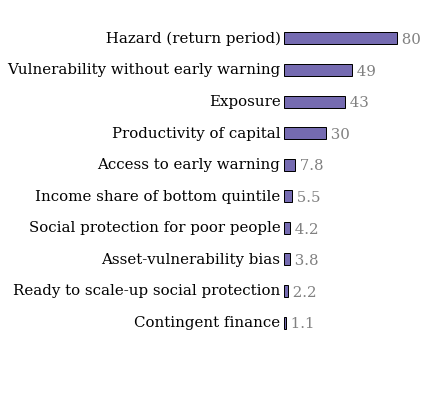

In [38]:
plot_barh(info.sort_values("risk", ascending=True).risk.tail(10), color="#756bb1", xlabel="Average error (%)")
plt.savefig("img/risk_info.png", bbox_inches="tight")

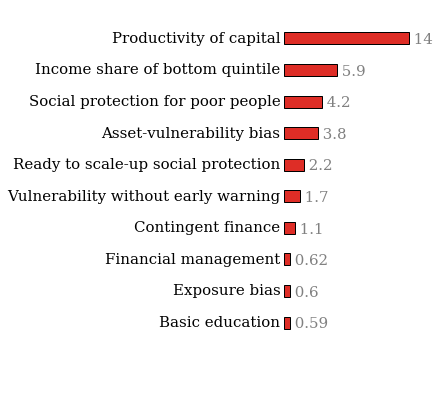

In [39]:
plot_barh(info.sort_values("resilience", ascending=True).resilience.tail(10), color="#de2d26")
plt.savefig("img/ser_info.png", bbox_inches="tight")

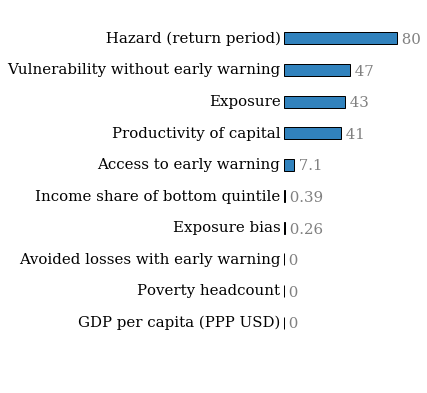

In [40]:
plot_barh(info.sort_values("risk_to_assets", ascending=True).risk_to_assets.tail(10), color="#3182bd")
plt.savefig("img/risk_to_assets_info.png", bbox_inches="tight")